In [27]:
%load_ext autoreload
%autoreload 2

import jax
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Dict, Optional

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import jaxley as jx
from jaxley.channels import HH, Leak
from jaxley.connection import connect

from jaxley_mech.synapses.nhka14 import mGluR6, META
from jaxley_mech.synapses.ribbon_mGluR6 import Ribbon_mGluR6
from jaxley_mech.channels.kwu09 import Leak, Kv, Ca, CaNernstReversal, KCa, ClCa, Hyper, CaPump
from jaxley_mech.channels.fm97 import K
from jaxley_mech.channels.chen24 import Phototransduction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
META

{'reference_1': 'Nishiyama, S., Hosoki, Y., Koike, C., & Amano, A. (2014). IEEE, 6116-6119.',
 'reference_2': 'Witkovsky, P., Schmitz, Y., Akopian, A., Krizaj, D., & Tranchina, D. (1997). Journal of Neuroscience, 17(19), 7297-7306.'}

Added 1 external_states. See `.externals` for details.


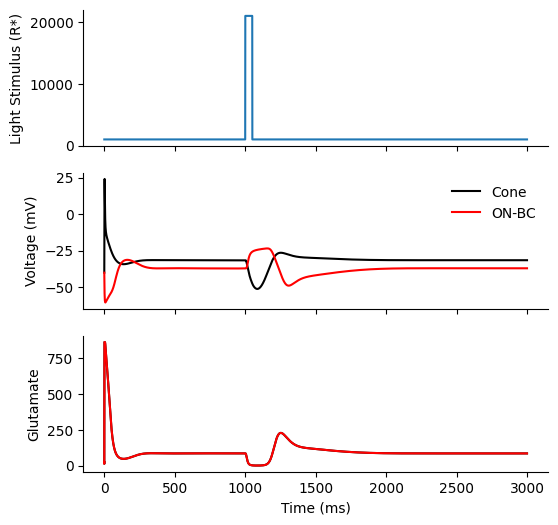

In [3]:
n_cells = 2
dt = 0.025
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=1)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])
connect(
    network.cell(0).branch(0).comp(0), network.cell(1).branch(0).comp(0), mGluR6()
)

# Insert mechanisms
# Cone
network.cell(0).insert(Kv())
network.cell(0).insert(Hyper())
network.cell(0).insert(Ca())
network.cell(0).insert(ClCa())
network.cell(0).insert(KCa())
network.cell(0).insert(CaPump())
network.cell(0).insert(CaNernstReversal())
network.cell(0).insert(Leak())
network.cell(0).insert(Phototransduction())
prefix = "Phototransduction"
params_mouse_cone = {
    f"{prefix}_sigma": 9.74, # /s, opsin decay rate constant
    f"{prefix}_phi": 9.74, # /s, PDE decay rate constant
    f"{prefix}_eta": 761, # /s, PDE dark activate rate
    f"{prefix}_gamma": 20, # unitless, Opsin gain
    f"{prefix}_beta": 2.64, # /s, Ca2+ extrusion rate constant
    f"{prefix}_k": 0.01, # pA / μM, cGMP-to-current constant
    f"{prefix}_m": 4, # unitless, Cooperativity of GC Ca2+ dependence
    f"{prefix}_n": 3, # unitless, cGMP cahnnel cooperativity
    f"{prefix}_K_GC": 0.4, # μM, Affinity of GC Ca2+ dependence
    f"{prefix}_G_dark": 20, # μM, cGMP concentration in dark
    f"{prefix}_C_dark": 1, # μM, Ca2+ concentration in dark   
}
for name, param in params_mouse_cone.items():
    network.cell(0).set(name, param)
# ON-BC
network.cell(1).insert(Kv())
network.cell(1).insert(Ca())
network.cell(1).insert(CaPump())
network.cell(1).insert(Hyper())
network.cell(1).insert(Leak())

network.init_states()

# Set voltages to resting membrane potential
network.cell([0, 1]).set("v", -40)

# Adjust the synapse strength
network.mGluR6(0).set("mGluR6_gTRPM1", 1.65 * 10**-3)

network.delete_recordings()
# Record voltage
network.cell(0).branch(0).comp(0).record(verbose=False)
network.cell(1).branch(0).loc(0).record(verbose=False)
# Record glutamate
network.cell(0).branch(0).comp(0).record("mGluR6_Glu", verbose=False)
network.cell(1).branch(0).loc(0).record("mGluR6_Glu", verbose=False)

# Design stimulus
background_intensity = 10e2
intensity = 20 * 10e2
pre_light_time = 1000  # ms
light_on_time = 50  # ms
total_time = pre_light_time + 2000 # ms
dt = 0.025 # ms
time_steps = int(total_time / dt)
Jhv = jnp.zeros(time_steps) + background_intensity
light_on_start = int(pre_light_time / dt)
light_on_end = int((pre_light_time + light_on_time) / dt)
Jhv = Jhv.at[light_on_start:light_on_end].set(background_intensity + intensity)

# Clamp the phototransduction current
network.cell(0).clamp("Phototransduction_Stim", Jhv)

v = jx.integrate(network, t_max=total_time, delta_t=dt, solver="fwd_euler")

fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
colors = ["k", "r"]
cells = ["Cone", "ON-BC"]
ramp_up = 0 # ms
time = jnp.arange(ramp_up, total_time, dt)

_ = ax[0].plot(time, Jhv[int(ramp_up/dt):])
for i in range(2):
    ax[1].plot(time, v[i, int(ramp_up/dt):-1], color=colors[i], label=cells[i])
    ax[2].plot(time, v[i + 2, int(ramp_up/dt):-1], color=colors[i], label=cells[i])

ax[0].set_ylabel("Light Stimulus (R*)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].legend(frameon=False)
ax[2].set_ylabel("Glutamate")
ax[2].set_xlabel("Time (ms)")

sns.despine();

TODO
- use ribbon synapse model for glutamate release

Added 1 external_states. See `.externals` for details.


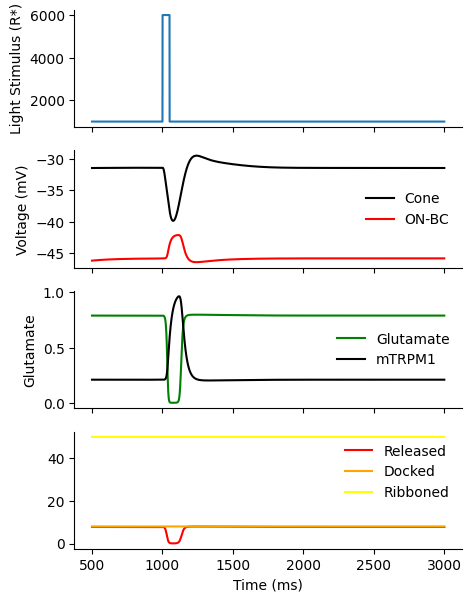

In [34]:
n_cells = 2
dt = 0.025
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=1)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])
connect(
    network.cell(0).branch(0).comp(0), network.cell(1).branch(0).comp(0), Ribbon_mGluR6()
)

# Insert mechanisms
# Cone
network.cell(0).insert(Kv())
network.cell(0).insert(Hyper())
network.cell(0).insert(Ca())
network.cell(0).insert(ClCa())
network.cell(0).insert(KCa())
network.cell(0).insert(CaPump())
network.cell(0).insert(CaNernstReversal())
network.cell(0).insert(Leak())
network.cell(0).insert(Phototransduction())
prefix = "Phototransduction"
params_mouse_cone = {
    f"{prefix}_sigma": 9.74, # /s, opsin decay rate constant
    f"{prefix}_phi": 9.74, # /s, PDE decay rate constant
    f"{prefix}_eta": 761, # /s, PDE dark activate rate
    f"{prefix}_gamma": 20, # unitless, Opsin gain
    f"{prefix}_beta": 2.64, # /s, Ca2+ extrusion rate constant
    f"{prefix}_k": 0.01, # pA / μM, cGMP-to-current constant
    f"{prefix}_m": 4, # unitless, Cooperativity of GC Ca2+ dependence
    f"{prefix}_n": 3, # unitless, cGMP cahnnel cooperativity
    f"{prefix}_K_GC": 0.4, # μM, Affinity of GC Ca2+ dependence
    f"{prefix}_G_dark": 20, # μM, cGMP concentration in dark
    f"{prefix}_C_dark": 1, # μM, Ca2+ concentration in dark   
}
for name, param in params_mouse_cone.items():
    network.cell(0).set(name, param)
# ON-BC
network.cell(1).insert(Kv())
network.cell(1).insert(Ca())
network.cell(1).insert(CaPump())
network.cell(1).insert(Hyper())
network.cell(1).insert(Leak())

network.init_states()

# Set voltages to resting membrane potential
network.cell([0, 1]).set("v", -50)

# Adjust the synapse strength
network.Ribbon_mGluR6(0).set("Ribbon_mGluR6_gTRPM1", 1.65 * 10**-4) # 1.65 * 10**-2
network.Ribbon_mGluR6(0).set("Ribbon_mGluR6_V_half", -35)
network.Ribbon_mGluR6(0).set("Ribbon_mGluR6_p_r", 1.0)

network.delete_recordings()
# Record voltage
network.cell(0).branch(0).comp(0).record(verbose=False)
network.cell(1).branch(0).loc(0).record(verbose=False)
# Record glutamate
network.cell(1).branch(0).loc(0).record("Ribbon_mGluR6_Glu", verbose=False)
network.cell(1).branch(0).loc(0).record("Ribbon_mGluR6_mTRPM1", verbose=False)
network.cell(1).branch(0).loc(0).record("Ribbon_mGluR6_released", verbose=False)
network.cell(1).branch(0).loc(0).record("Ribbon_mGluR6_docked", verbose=False)
network.cell(1).branch(0).loc(0).record("Ribbon_mGluR6_ribboned", verbose=False)

# Design stimulus
background_intensity = 1000
intensity = 5000
pre_light_time = 1000  # ms
light_on_time = 50  # ms
total_time = pre_light_time + 2000 # ms
dt = 0.025 # ms
time_steps = int(total_time / dt)
Jhv = jnp.zeros(time_steps) + background_intensity
light_on_start = int(pre_light_time / dt)
light_on_end = int((pre_light_time + light_on_time) / dt)
Jhv = Jhv.at[light_on_start:light_on_end].set(background_intensity + intensity)

# Clamp the phototransduction current
network.cell(0).clamp("Phototransduction_Stim", Jhv)

v = jx.integrate(network, t_max=total_time, delta_t=dt, solver="fwd_euler")

fig, ax = plt.subplots(4, 1, figsize=(5, 7), sharex=True)
colors = ["k", "r"]
cells = ["Cone", "ON-BC"]
ramp_up = 500 # ms
time = jnp.arange(ramp_up, total_time, dt)

_ = ax[0].plot(time, Jhv[int(ramp_up/dt):])
for i in range(2):
    ax[1].plot(time, v[i, int(ramp_up/dt):-1], color=colors[i], label=cells[i])

colors = ["g", "k"]
labels = ["Glutamate", "mTRPM1"]
# normalize the glutamate
KGlu = network.Ribbon_mGluR6(0).view["Ribbon_mGluR6_KGlu"].values[0]
ufunc = lambda v: v**2 / (v**2 + KGlu**2)
v = v.at[2, :].apply(ufunc)
for  i in range(2, 4):
    ax[2].plot(time, v[i, int(ramp_up/dt):-1], color=colors[i-2], label=labels[i-2])

colors = ["r", "orange", "yellow"]
labels = ["Released", "Docked", "Ribboned"]
for i in range(4, 7):
    ax[3].plot(time, v[i, int(ramp_up/dt):-1], color=colors[i-4], label=labels[i-4])

ax[0].set_ylabel("Light Stimulus (R*)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].legend(frameon=False)
ax[2].set_ylabel("Glutamate")
ax[2].legend(frameon=False)
ax[3].legend(frameon=False)
ax[3].set_xlabel("Time (ms)")
#ax[3].set_ylim(0, 10)

sns.despine();

TODO
- normalized glutamate release should be 1.0 in complete darkness, depends on the probabilities though to get maximal release